Каждый из нас писал в школе и университете изложения, сочинения, рефераты. А значит, в каждом из нас живет великий русский писатель.
В этой работе будем раскрывать свои таланты, находить себя в ряду таких гениев, как Пушкин, Гоголь, Грибоедов

В этой работе
- скачаем корпус текстов 20-ми русских писателей. Каждый текст разобьем на обучающую и тестовую выборки.
- разработаем и обучим нейронную сеть определяющию авторство фрагментов текста (по тестовой выборке)
- скачаем СВОЕ сочинение (или чье-нибудь - есть в архиве). Сделаем из него проверочную выборку
- предложим нейронке предсказать автора сочинения (по проверочной выборке)
- объявим себя великим писателем, например, Гончаровым

Ссылка на архив: https://storage.yandexcloud.net/aiueducation/Content/base/l7/20writers.zip

В работе рекомендуется пользоваться материалами из ноутбука практического занятия "Рекуррентные и одномерные сверточные нейронные сети". Допускается выбрать лучший вариант нейронки и адаптировать ее структуру, параметры обучения и формирования датасетов под свои *нужды*

In [ ]:
# Импортируем все необходимые библиотеки
import os

import gdown

import zipfile

import string

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer

from tensorflow.keras.preprocessing.sequence import pad_sequences

# Функции-утилиты для работы с категориальными данными
from tensorflow.keras.utils import to_categorical

# Класс для конструирования последовательной модели нейронной сети
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional

from tensorflow.keras.optimizers import Adam


%matplotlib inline

In [7]:
# Папка с текстами
DATA_DIR = '/kaggle/input/20writers'  # Путь к подкаталогу

# Проверим содержимое подкаталога 20writers
files = os.listdir(DATA_DIR)
print(f"Files in the directory: {files}")

Files in the directory: ['Булгаков.txt', 'Достоевский.txt', 'Пастернак.txt', 'Шолохов.txt', 'Гончаров.txt', 'Куприн.txt', 'Горький.txt', 'Беляев.txt', 'Лесков.txt', 'Носов.txt', 'Чехов.txt', 'Тургенев.txt', 'Грибоедов.txt', 'Пушкин.txt', 'Лермонтов.txt', 'Катаев.txt', 'Гоголь.txt', 'Каверин.txt', 'Толстой.txt', 'Васильев.txt']


In [8]:
# Списки для хранения данных и меток
texts = []
labels = []

# Чтение и разбиение текста на фрагменты
for filename in os.listdir(DATA_DIR):
    if filename.endswith('.txt') and filename.lower() != 'readme.txt':
        author = filename.replace('.txt', '').strip()
        with open(os.path.join(DATA_DIR, filename), 'r', encoding='utf-8') as f:
            text = f.read().replace('\n', ' ')
            fragments = text.split('.')  # грубое разбиение по предложениям
            fragments = ['.'.join(fragments[i:i+5]) for i in range(0, len(fragments), 5)]  # по 5 предложений
            for frag in fragments:
                if len(frag.split()) > 20:  # чтобы отсеять слишком короткие
                    texts.append(frag)
                    labels.append(author)


In [9]:
# Создание словаря авторов
unique_authors = sorted(list(set(labels)))
author_to_index = {author: idx for idx, author in enumerate(unique_authors)}
y = [author_to_index[a] for a in labels]

In [ ]:
# Преобразование текста в последовательности
VOCAB_SIZE = 20000
MAX_LEN = 500  # Максимальная длина последовательности

# Разделение на обучение и тест
X_train, X_test, y_train, y_test = train_test_split(texts, y, test_size=0.2, stratify=y, random_state=42)

In [11]:
tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

# Преобразуем текст в последовательности чисел
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [13]:
# Padding
X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN)
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_LEN)

In [14]:
# One-hot encoding для меток
y_train_cat = to_categorical(y_train, num_classes=len(unique_authors))
y_test_cat = to_categorical(y_test, num_classes=len(unique_authors))

In [20]:
# Определение модели
model = Sequential()
model.add(Embedding(input_dim=VOCAB_SIZE, output_dim=128, input_length=MAX_LEN))
model.add(LSTM(64, return_sequences=False)) 
model.add(Dropout(0.3))
model.add(Dense(len(unique_authors), activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='Adam',  
              metrics=['accuracy'])

In [21]:
# Обучение модели
history = model.fit(X_train_pad,
                    y_train_cat,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.2)

Epoch 1/10
   1/2321 ━━━━━━━━━━━━━━━━━━━━ 1:46:15 3s/step - accuracy: 0.0000e+00 - loss: 3.0036

I0000 00:00:1748174628.016545      82 cuda_dnn.cc:529] Loaded cuDNN version 90300


2321/2321 ━━━━━━━━━━━━━━━━━━━━ 48s 20ms/step - accuracy: 0.2104 - loss: 2.5446 - val_accuracy: 0.4889 - val_loss: 1.6321
Epoch 2/10
2321/2321 ━━━━━━━━━━━━━━━━━━━━ 45s 19ms/step - accuracy: 0.5976 - loss: 1.3004 - val_accuracy: 0.7209 - val_loss: 0.9435
Epoch 3/10
2321/2321 ━━━━━━━━━━━━━━━━━━━━ 45s 20ms/step - accuracy: 0.8270 - loss: 0.5913 - val_accuracy: 0.7786 - val_loss: 0.7653
Epoch 4/10
2321/2321 ━━━━━━━━━━━━━━━━━━━━ 45s 20ms/step - accuracy: 0.9172 - loss: 0.2891 - val_accuracy: 0.7874 - val_loss: 0.7901
Epoch 5/10
2321/2321 ━━━━━━━━━━━━━━━━━━━━ 45s 20ms/step - accuracy: 0.9555 - loss: 0.1592 - val_accuracy: 0.7839 - val_loss: 0.8735
Epoch 6/10
2321/2321 ━━━━━━━━━━━━━━━━━━━━ 45s 19ms/step - accuracy: 0.9730 - loss: 0.0943 - val_accuracy: 0.7786 - val_loss: 0.9971
Epoch 7/10
2321/2321 ━━━━━━━━━━━━━━━━━━━━ 45s 19ms/step - accuracy: 0.9815 - loss: 0.0646 - val_accuracy: 0.7737 - val_loss: 1.0789
Epoch 8/10
2321/2321 ━━━━━━━━━━━━━━━━━━━━ 45s 19ms/step - accuracy: 0.9854 - loss: 0.04

In [22]:
# Оценка на тестовой выборке
test_loss, test_accuracy = model.evaluate(X_test_pad, y_test_cat)
print(f'Test Accuracy: {test_accuracy:.4f}')

726/726 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.7761 - loss: 1.2488
Test Accuracy: 0.7797


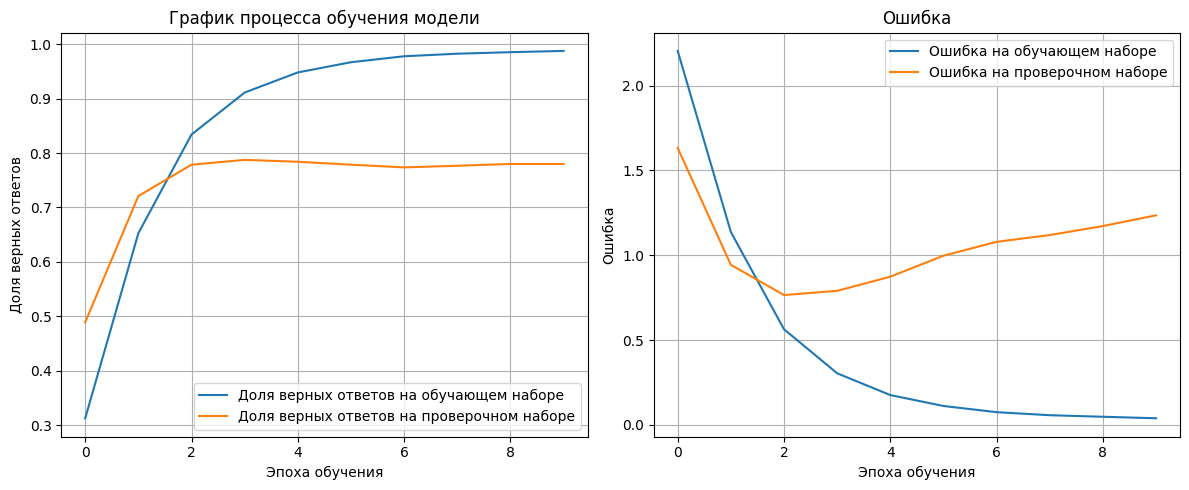

In [23]:
# График точности (доля верных ответов)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], label='Доля верных ответов на проверочном наборе')
plt.title('График процесса обучения модели')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.grid(True)

# График функции потерь (ошибка)
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], label='Ошибка на проверочном наборе')
plt.title('Ошибка')
plt.xlabel('Эпоха обучения')
plt.ylabel('Ошибка')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [24]:
# Функция для предсказания автора нового текста
def preprocess_text(text):
    text = text.lower()  # Преобразуем в нижний регистр
    text = text.translate(str.maketrans('', '', string.punctuation))  # Убираем знаки препинания
    return text

def predict_author(new_text, model, tokenizer, maxlen):
    new_text = preprocess_text(new_text)
    new_text_seq = tokenizer.texts_to_sequences([new_text])
    new_text_pad = pad_sequences(new_text_seq, maxlen=maxlen)

    prediction = model.predict(new_text_pad)
    predicted_label = prediction.argmax(axis=1)

    predicted_author = unique_authors[predicted_label[0]]
    return predicted_author

In [25]:
# Пример использования предсказания на новом тексте
my_text = """Современные инфокоммуникационные системы играют ключевую роль 
            в организации эффективного управления здравоохранением. 
            Больницы и медицинские учреждения сталкиваются с растущими объемами данных, 
            которые необходимо обрабатывать, хранить и анализировать для обеспечения высокого 
            качества медицинских услуг. Разработка базы данных для инфокоммуникационной системы 
            больницы становится неотъемлемой частью этого процесса, так как она позволяет 
            оптимизировать работу с информацией, улучшить взаимодействие между медицинским 
            персоналом и пациентами, а также повысить уровень безопасности и конфиденциальности данных.
            В рамках данного курсового проекта будет предложен комплексный подход к 
            проектированию и реализации базы данных, которая будет включать в себя 
            основные элементы, такие как учет пациентов, управление медицинскими записями, 
            назначение лекарств, учет сотрудников и должностей. Особое внимание будет уделено 
            вопросам интеграции с существующими информационными системами больницы, а также 
            обеспечению надежности и масштабируемости разработанной базы данных."""

predicted_author = predict_author(my_text, model, tokenizer, MAX_LEN)
print(f'Предсказанный автор: {predicted_author}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
Предсказанный автор: Беляев
